# Projet 5GMM

Travailler sur les données "train"

1- Isoler la variable Y (analyse descriptive dessus)

2- Travailler sur les mots -> apparitions, corrélations

3- Sur les variables quantitatives (histogrammes, corrélation entre les variables)

4- ACP et étude de l'ébouli des valeurs propres : essayer de faire des groupes sur les Y pour représenter dans l'ACP
	-> Prédire le Y sur le plan factoriel de l'ACP


## Les donnéées

1:50: Average, standard deviation, min, max and median of the attributes 51...60 for the source of the current blog post

51: Total number of comments before basetime 

52: Number of comments in the last 24 hours before the basetime 

53: Let T1 denote the datetime 48 hours before basetime, let T2 denote the datetime 24 hours before basetime. This attribute is the number of comments in the time period between T1 and T2 

54: Number of comments in the first 24 hours after the publication of the blog post, but before basetime 

55: The difference of Attribute 52 and Attribute 53 

56...60: The same features as the attributes 51...55, but features 56...60 refer to the number of links (trackbacks), while features 51...55 refer to the number of comments. 

61: The length of time between the publication of the blog post and basetime 

62: The length of the blog post 

63...262: The 200 bag of words features for 200 frequent words of the text of the blog post 

263...269: binary indicator features (0 or 1) for the weekday (Monday...Sunday) of the basetime 

270...276: binary indicator features (0 or 1) for the weekday (Monday...Sunday) of the date of publication of the blog post 

277: Number of parent pages: we consider a blog post P as a parent of blog post B, if B is a reply (trackback) to blog post P. 

278...280: Minimum, maximum, average number of comments that the parents received 

281: The target: the number of comments in the next 24 hours (relative to basetime)

In [1]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import csv
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import pandas as pd
import seaborn as sns

In [2]:
#Fonction pour lire les données dans le CSV et les transformer en un tableau de nombres
def lire_csv(Nom):
    fichier_lire=open(Nom)

    fichier=csv.reader(fichier_lire, delimiter=",")
    fichier=list(fichier)
    tab2=np.array(fichier)
    #tab2=np.delete(tab2, (0),axis=0)
    
    for i in range(0,np.shape(tab2)[0]):
        for j in range(2,10):
            tab2[i][j]=np.copy(float(tab2[i][j].replace(",",".")))
       
    return tab2;

In [3]:
#Data est le tableau de toutes les données "train"
Data=lire_csv("blogData_train.csv")
Data=Data.astype(np.float)

In [4]:
#Y est la variable à prédire, ici c'est la 281ème colonne
Y=Data[:,280]
print(Y)

#Mots est la matrice contenant l'apparition ou non apparition des mots clés, ici c'est les lignes 62 à 262
Mots=Data[:, 61:261]
print(Mots)

[ 1.  0.  0. ...,  0.  0.  0.]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [5]:
stats.describe(Y)

DescribeResult(nobs=52397, minmax=(0.0, 1424.0), mean=6.7647193541614978, variance=1421.7850114550367, skewness=12.691311246278929, kurtosis=232.29540940625407)

### Description de la variable à prédire Y

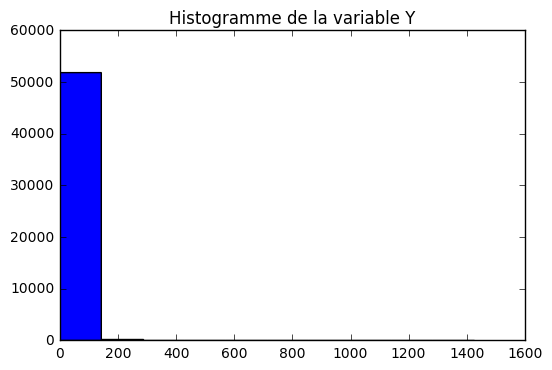

In [6]:
plt.hist(Y)
plt.title("Histogramme de la variable Y")
plt.show()

In [7]:
print("Nombre différents de 0 dans le vecteur Y : ", len(Y[Y!=0]))
print("Proportion de 0 dans le vecteur Y : ", 1-(len(Y[Y!=0])/len(Y)))

Nombre différents de 0 dans le vecteur Y :  18838
Proportion de 0 dans le vecteur Y :  0.6404755997480771


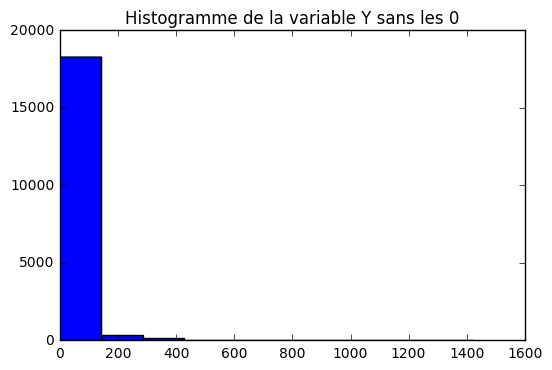

In [8]:
plt.hist(Y[Y!=0])
plt.title("Histogramme de la variable Y sans les 0")
plt.show()

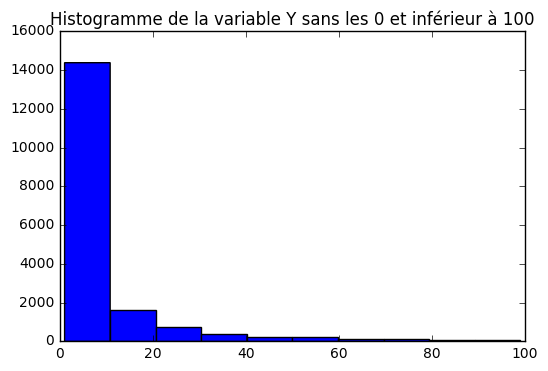

In [9]:
Y_sans0=Y[Y!=0]
plt.hist(Y_sans0[Y_sans0<100])
plt.title("Histogramme de la variable Y sans les 0 et inférieur à 100")
plt.show()

On remarque que 64% des nombres de commentaires valent 0 et plus de 75% valent 0 ou 1.
Cependant, il y a une grande dispersion des autres valeurs.

Dans un second temps, nous allons essayer de travailler avec une variable Y qui soit quantitative (à faire).

In [10]:
#Discretisation de la variale Y
#Equal0
#0_10
#Sup10

Y_Quali=np.zeros((np.shape(Y)[0],))
liste=[]

for i in range(0, np.shape(Y)[0]):
    if Y[i]==0:
        liste.append("Equal0")
    elif Y[i]>0 and Y[i]<10:
        liste.append("Entre0_10")
    elif Y[i]>=10:
        liste.append("Sup10")

## Les mots présents

Travail descriptif pour les variables correspondantes aux apparitions des différents mots.

In [11]:
Mots=Data[:, 62:261]

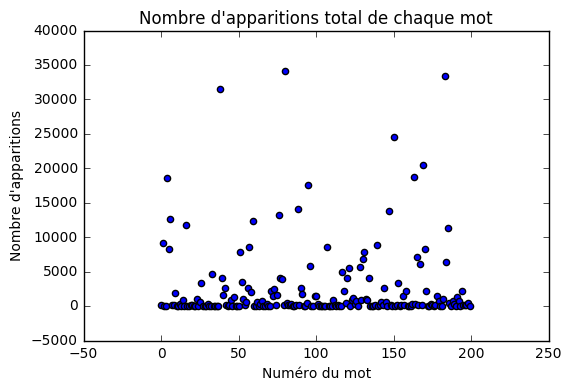

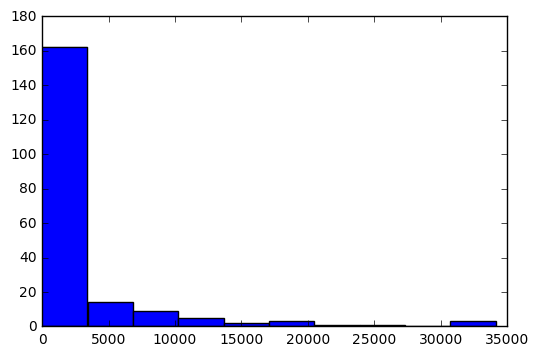

In [12]:
Appar_Mots=np.zeros((200))
for i in range(0, 199):
    Appar_Mots[i]=np.sum(Mots[:,i])  

plt.scatter(np.arange(0,200),Appar_Mots)
plt.title("Nombre d'apparitions total de chaque mot")
plt.xlabel("Numéro du mot")
plt.ylabel("Nombre d'apparitions")
plt.show()
plt.hist(Appar_Mots)
plt.show()

In [13]:
stats.describe(Appar_Mots)

DescribeResult(nobs=200, minmax=(0.0, 34139.0), mean=2551.0799999999999, variance=31393769.008643214, skewness=3.4662552767445773, kurtosis=13.507010613325772)

In [14]:
len(Appar_Mots[Appar_Mots<1000])

133

La majorité des mots apparaissent pour peu d'individus, il va donc falloir faire un tri.

Face à cela, certains mots apparaissent dans presque tous les articles (individus).

Corrélations entre les mots :

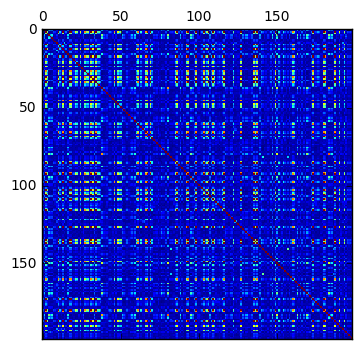

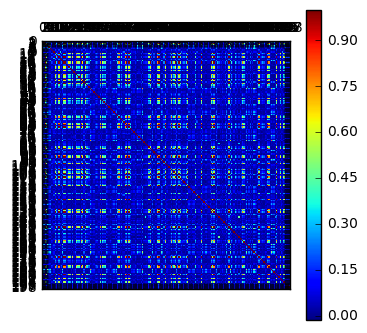

In [34]:
Mots_Panda=pd.DataFrame(Mots)
plt.matshow(Mots_Panda.corr())
plt.xticks(range(len(Mots_Panda.columns)), Mots_Panda.columns)
plt.yticks(range(len(Mots_Panda.columns)), Mots_Panda.columns)
plt.colorbar()
plt.show()

In [15]:
Mots_50=Mots[:, 0:49]
Mots_100=Mots[:, 50:99]
Mots_150=Mots[:, 100:149]
Mots_200=Mots[:, 150:199]
Mots_50_Panda=pd.DataFrame(Mots_50)

## Variables qualitatives et indicateurs

Ici, on s'intéresse aux 50 premières variables qui sont les indicateurs sur le nombre de commentaires avant notre date.

In [17]:
Indi=Data[:,0:49]

In [20]:
Indi_Panda=pd.DataFrame(Indi)

In [21]:
Indi2=Data[:,0:5]
Indi_Panda2=pd.DataFrame(Indi2)

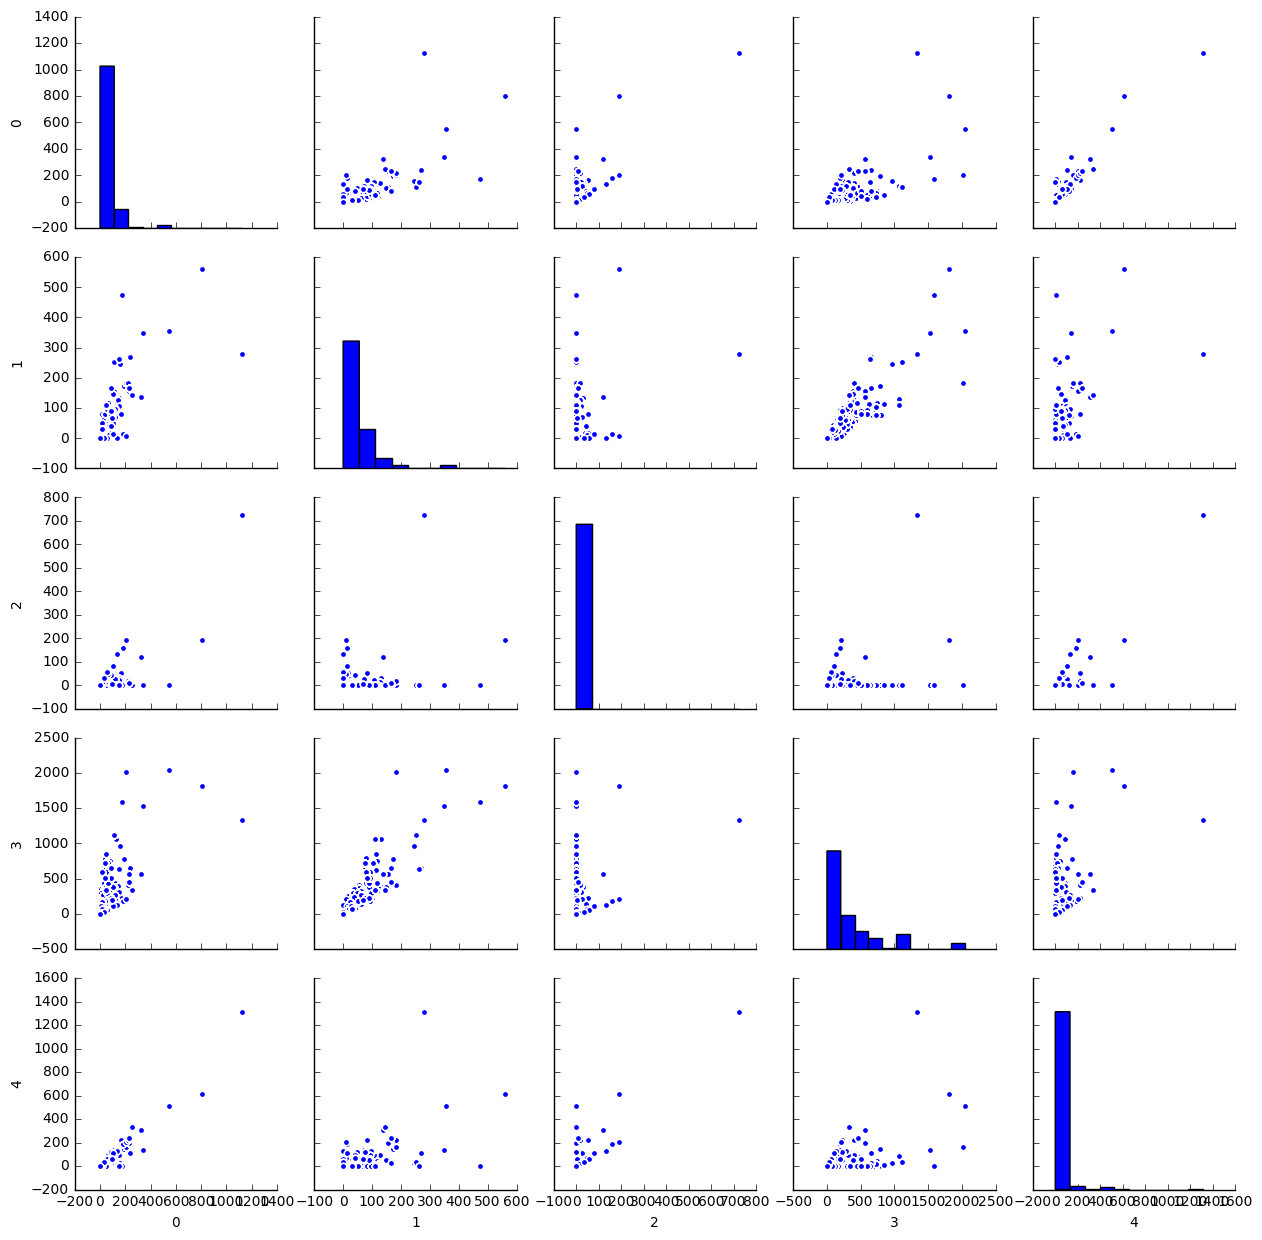

In [23]:
sns.pairplot(Indi_Panda2, kind="scatter")
plt.show()

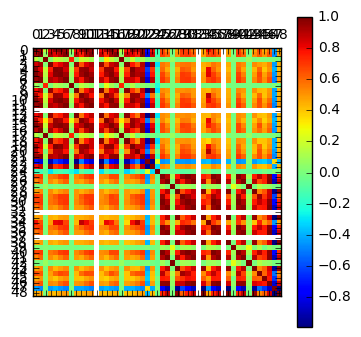

In [14]:
plt.matshow(Indi_Panda.corr())
plt.xticks(range(len(Indi_Panda.columns)), Indi_Panda.columns)
plt.yticks(range(len(Indi_Panda.columns)), Indi_Panda.columns)
plt.colorbar()
plt.show()

In [31]:
Indi_Panda.corr()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.000000,0.926063,0.153651,0.852126,0.973861,0.996860,0.941574,0.091091,0.795670,0.921001,...,0.676312,0.535100,0.008172,0.474527,0.663158,0.462910,0.588045,-0.430831,0.456317,0.002992
1,0.926063,1.000000,0.062471,0.923558,0.826808,0.913370,0.991400,0.017353,0.876339,0.753083,...,0.695246,0.604857,-0.005998,0.518617,0.630570,0.506877,0.640441,-0.467591,0.483224,0.002762
2,0.153651,0.062471,1.000000,0.022318,0.182835,0.145746,0.101145,0.749392,0.015544,0.198764,...,0.013064,-0.000422,0.081603,-0.006324,0.025694,0.004179,0.007439,0.004175,-0.002759,-0.013456
3,0.852126,0.923558,0.022318,1.000000,0.765456,0.825913,0.913739,0.005770,0.959883,0.644830,...,0.569128,0.521621,-0.015137,0.525901,0.483146,0.453277,0.527221,-0.438498,0.454094,-0.006910
4,0.973861,0.826808,0.182835,0.765456,1.000000,0.977636,0.854387,0.126099,0.704929,0.960397,...,0.599619,0.462603,0.014236,0.426797,0.602223,0.396297,0.509220,-0.388761,0.418736,0.006463
5,0.996860,0.913370,0.145746,0.825913,0.977636,1.000000,0.931110,0.088670,0.770021,0.941931,...,0.682281,0.543814,0.006386,0.481940,0.667564,0.472375,0.597371,-0.445644,0.471862,0.003505
6,0.941574,0.991400,0.101145,0.913739,0.854387,0.931110,1.000000,0.046142,0.889602,0.774960,...,0.709332,0.616270,0.002467,0.531006,0.645768,0.513447,0.653376,-0.479324,0.496025,0.001979
7,0.091091,0.017353,0.749392,0.005770,0.126099,0.088670,0.046142,1.000000,0.000688,0.155860,...,-0.010592,-0.016586,-0.000610,-0.016128,-0.005203,-0.010875,-0.013276,0.017567,-0.016801,-0.000322
8,0.795670,0.876339,0.015544,0.959883,0.704929,0.770021,0.889602,0.000688,1.000000,0.570294,...,0.525983,0.498073,-0.014870,0.510052,0.427722,0.412330,0.494242,-0.422374,0.439828,-0.007829
9,0.921001,0.753083,0.198764,0.644830,0.960397,0.941931,0.774960,0.155860,0.570294,1.000000,...,0.593770,0.461795,0.002716,0.420015,0.594687,0.406728,0.514198,-0.412661,0.443905,-0.004633


## ACP

ACP sur les 50 premières variables (sans les mots, les jours et la variable Y)

In [41]:
X=scale(Data[:, 1:50])

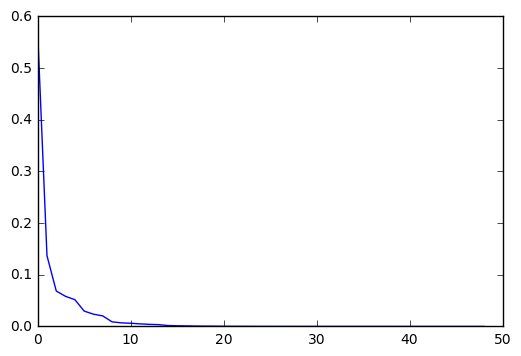

In [42]:
pca = PCA()
## Estimation, calcul des composantes principales
C = pca.fit(X).transform(X)
## Décroissance de la variance expliquée
plt.plot(pca.explained_variance_ratio_)
plt.show()

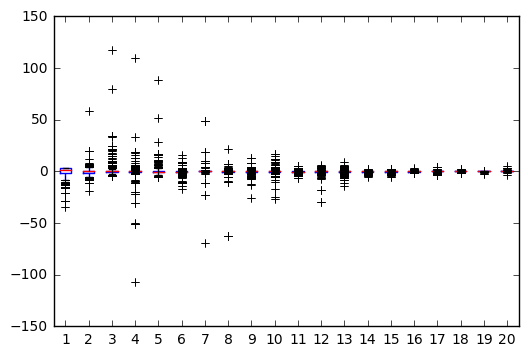

In [31]:
## distribution des composantes principales
plt.boxplot(C[:,0:20])
plt.show()

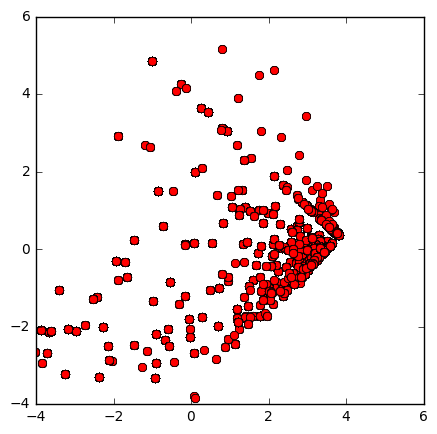

In [34]:
## Repésentation des individus
plt.figure(figsize=(5,5))
for i, j in zip(C[:,0], C[:,1]):
    plt.plot(i, j, "o",color="red")
plt.axis((-4,6,-4,6))  
plt.show()

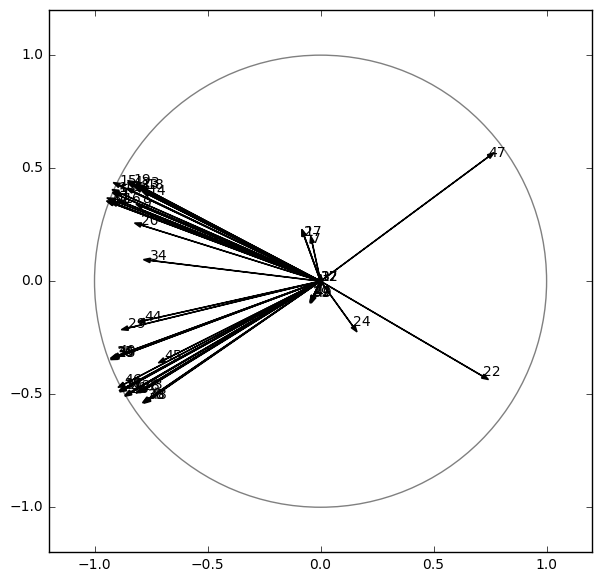

In [33]:
## coordonnées et représentation des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, np.arange(1, 281)):
    plt.text(i,j, nom)
    plt.arrow(0,0,i,j,color='black')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
ax.add_patch(c)
plt.show()

In [43]:
pca.explained_variance_ratio_

array([  5.69299461e-01,   1.36904793e-01,   6.85218752e-02,
         5.82118891e-02,   5.17830785e-02,   2.97188197e-02,
         2.37226581e-02,   2.03613395e-02,   8.87671501e-03,
         6.91245096e-03,   6.16352942e-03,   4.96599473e-03,
         4.03961813e-03,   3.47988277e-03,   1.75188491e-03,
         1.29745093e-03,   1.03067827e-03,   7.00082672e-04,
         5.50517598e-04,   4.78998430e-04,   2.86787496e-04,
         2.25301438e-04,   1.64744101e-04,   1.37992951e-04,
         8.10748893e-05,   7.34844829e-05,   5.51650403e-05,
         4.61583595e-05,   3.34377214e-05,   2.63591016e-05,
         2.00319335e-05,   1.70840897e-05,   1.62102873e-05,
         1.39693383e-05,   8.38280434e-06,   7.02602546e-06,
         4.20711428e-06,   4.03430273e-06,   2.45586929e-06,
         1.82881572e-06,   1.30707499e-06,   1.23869675e-06,
         5.98111760e-18,   1.59539897e-18,   1.55264532e-31,
         6.08348298e-32,   4.57138250e-33,   4.57138250e-33,
         4.23983786e-33]

Même ACP mais avec toutes les variables

In [37]:
X=scale(Data[:, 0:279])

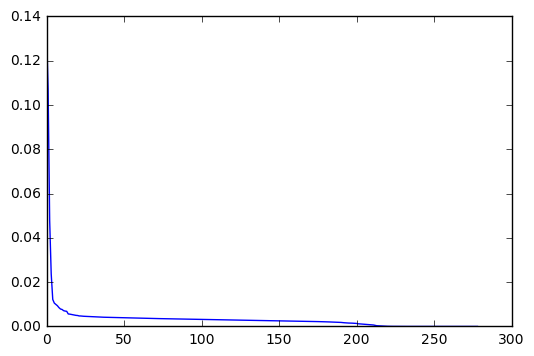

In [38]:
pca = PCA()
## Estimation, calcul des composantes principales
C = pca.fit(X).transform(X)
## Décroissance de la variance expliquée
plt.plot(pca.explained_variance_ratio_)
plt.show()

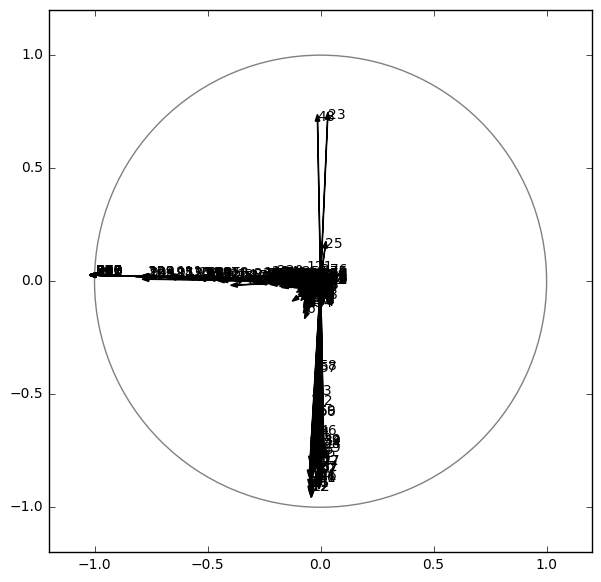

In [39]:
## coordonnées et représentation des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, np.arange(1, 281)):
    plt.text(i,j, nom)
    plt.arrow(0,0,i,j,color='black')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
ax.add_patch(c)
plt.show()

In [40]:
pca.explained_variance_ratio_

array([  1.32963543e-01,   1.07269986e-01,   4.79398087e-02,
         2.37035871e-02,   1.21858606e-02,   1.05445964e-02,
         9.94698814e-03,   9.35880203e-03,   8.49778483e-03,
         7.86866504e-03,   7.66466778e-03,   7.12660376e-03,
         6.93889403e-03,   6.83176022e-03,   5.63712534e-03,
         5.55699330e-03,   5.41592786e-03,   5.31558468e-03,
         5.17750322e-03,   5.00328961e-03,   4.94473887e-03,
         4.75073642e-03,   4.72460963e-03,   4.64145793e-03,
         4.59421476e-03,   4.55824222e-03,   4.51530392e-03,
         4.46402054e-03,   4.43731063e-03,   4.40916851e-03,
         4.39127804e-03,   4.35750104e-03,   4.30503040e-03,
         4.28523414e-03,   4.26391722e-03,   4.21716825e-03,
         4.17779472e-03,   4.15991711e-03,   4.14115153e-03,
         4.11565861e-03,   4.09939290e-03,   4.06211921e-03,
         4.05332518e-03,   4.02695836e-03,   4.01030535e-03,
         3.99806214e-03,   3.97163666e-03,   3.95447559e-03,
         3.93200157e-03,

Cette ACP n'est pas très intéressante car seulement 23% de la variance est expliquée sur 2 variables.